In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import numpy   as np
import sklearn as skl

import matplotlib.pyplot as plt
import seaborn           as srn

from scipy.optimize import minimize

from sklearn.model_selection       import train_test_split
from sklearn.svm                   import OneClassSVM
from scipy.stats                   import beta

In [2]:
np.random.seed(42)
N = 10**4
D = 1

X     = beta.rvs(a = 2, b = 2, size = N)[:,np.newaxis]
pStar = lambda x: beta.pdf(x, a = 2, b = 2)

XTr, XTe = train_test_split(X, train_size = 0.80, test_size = 0.20, random_state = 42)
XTe      = XTe[np.argsort(XTe.flatten()),:]

## Explicit optimisation

In [3]:
def relu(x):
    y = x
    y[y < 0] = 0
    return y

def dRelu(x):
    y = x
    y[x <= 0] = 0
    y[x > 0]  = np.ones((len(x[x > 0]),))
    return y

In [4]:
def svmScore(X, w):
    return X.dot(w)

def ocsvm_obj(theta, X, nu, D):
    
    w = theta[:D]
    r = theta[D:]
    
    term1 = 0.5 * np.sum(w**2)
    term2 = 1/nu * np.mean(relu(r - svmScore(X, w)))
    term3 = -r
    
    return term1 + term2 + term3

def ocsvm_grad(theta, X, nu, D):
    
    w = theta[:D]
    r = theta[D:]
    
    deriv = dRelu(r - svmScore(X, w))

    term1 = np.append(w, 0)
    term2 = np.append(1/nu * np.mean(deriv[:,np.newaxis] * (-X), axis = 0),
                      1/nu * np.mean(deriv))
    term3 = np.append(0*w, -1)

    grad = term1 + term2 + term3
    
    return grad

In [5]:
nu = 0.04

theta0 = np.random.normal(0, 1, D + 1)

from scipy.optimize import check_grad
print('Gradient error: %s' % check_grad(ocsvm_obj, ocsvm_grad, theta0, XTr, nu, D))

res = minimize(ocsvm_obj, theta0, 
               jac = ocsvm_grad, 
               args = (XTr, nu, D),
               method = 'L-BFGS-B',                
               options = {'gtol': 1e-8, 'disp': True, 'maxiter' : 50000, 'maxfun' : 10000})

wEXP = res.x[:-1]
rEXP = res.x[-1]

#print(ocsvm_grad(res.x, XTr, nu, D))

Gradient error: 1.7559573392555983e-08


## sklearn optimisation

In [6]:
ocSKL = OneClassSVM(nu = nu, kernel = 'linear')
ocSKL.fit(XTr)

#print(ocsvm_grad(np.concatenate([ ocSKL.coef_/(nu * XTr.shape[0]), [ ocSKL.intercept_/(nu * XTr.shape[0]) ] ]).flatten(), XTr, nu, D))

OneClassSVM(cache_size=200, coef0=0.0, degree=3, gamma='auto',
      kernel='linear', max_iter=-1, nu=0.04, random_state=None,
      shrinking=True, tol=0.001, verbose=False)

## Comparison of predictions

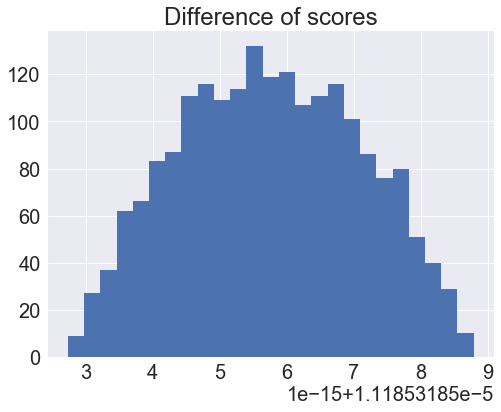

In [7]:
ocEXPScores = svmScore(XTe, wEXP) - rEXP
ocSKLScores = (ocSKL.decision_function(XTe).flatten())/(nu * XTr.shape[0])

srn.set(font_scale = 2);
plt.figure(figsize=(8,6));
plt.hist(ocEXPScores - ocSKLScores, bins = 25);
plt.title('Difference of scores');